In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


###################### Preprocessing #########################
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.impute import KNNImputer

In [50]:
df = pd.read_csv("data/aggregated.csv")
df.head()

id  ccf  age  sex  painloc  painexer  relrest  pncaden  cp  trestbps  ...  \
0   0    0   40    1        1         0        0       -9   2       140  ...   
1   1    0   49    0        1         0        0       -9   3       160  ...   
2   2    0   37    1        1         0        0       -9   2       130  ...   
3   3    0   48    0        1         1        1       -9   4       138  ...   
4   4    0   54    1        1         0        1       -9   3       150  ...   

   rcaprox  rcadist  lvx1  lvx2  lvx3  lvx4  lvf  cathef  junk  name  
0       -9       -9     1     1     1     1    1    -9.0  -9.0  name  
1       -9       -9     1     1     1     1    1    -9.0  -9.0  name  
2       -9       -9     1     1     1     1    1    -9.0  -9.0  name  
3        2       -9     1     1     1     1    1    -9.0  -9.0  name  
4        1       -9     1     1     1     1    1    -9.0  -9.0  name  

[5 rows x 76 columns]

# Data preprocessing

## Variables indicades com a irrellevants

Eliminem les columnes indicades com a "not used", "irrelevant", dates de proves o que són l'agregació d'altres variables.

In [51]:
print("Nombre de features abans:", len(df.columns))
useless_columns = ["id", "pncaden", "ccf", "dummy", "thalsev","thalpul", "earlobe", "lvx1", "lvx2", "lvx3", "lvx4", "lvf", "cathef", "junk", "xhypo", "name", "restckm", "exerckm", "proto", "cmo", "cday", "cyr", "ekgmo", "ekgday", "ekgyr", "pro"]
df.drop(useless_columns, axis = 1, inplace = True)

print("Nombre de features després:", len(df.columns))

Nombre de features abans: 76
Nombre de features després: 50


Proto és una categoria però està marcada com a float. No són consistents els valors. Convindria eliminar.

A xhypo no s'indica què representa.

- Pro és una variable que per si mateixa no hauria de ser un indicador de malaltia o no. La presència de pro vol dir que s'ha administrat una medicació que alleuja la càrrega del cor, de manera que els valors en altres proves sortiran inferiors als valors reals. Aquesta relació no la capturen la majoria de models plantejats (potser el random forest sí), i com que s'administra a malalts el model pot esbiaixar-se, de manera que pro = 1 ho indiqui com a malalt. Tot i així, quan fitegem el random forest no és de les variables més determinants. L'approach més adient seria fer feature engineering i modificar els valors relacionats amb l'electrocardiograma en cas de pro = 1. Tanmateix, ens falta informació sobre com s'haurien de modificar aquests valors.

## Assignació de categories

In [52]:
df.columns

Index(['age', 'sex', 'painloc', 'painexer', 'relrest', 'cp', 'trestbps', 'htn',
       'chol', 'smoke', 'cigs', 'years', 'fbs', 'dm', 'famhist', 'restecg',
       'dig', 'prop', 'nitr', 'diuretic', 'thaldur', 'thaltime', 'met',
       'thalach', 'thalrest', 'tpeakbps', 'tpeakbpd', 'trestbpd', 'exang',
       'oldpeak', 'slope', 'rldv5', 'rldv5e', 'ca', 'restef', 'restwm',
       'exeref', 'exerwm', 'thal', 'num', 'lmt', 'ladprox', 'laddist', 'diag',
       'cxmain', 'ramus', 'om1', 'om2', 'rcaprox', 'rcadist'],
      dtype='object')

In [53]:
categoriques = ['sex','painloc','painexer','relrest','cp','htn','smoke','fbs','dm','famhist', 'restecg', 'dig', 'prop', 'nitr', 'diuretic', 'exang', 'slope', 'restwm', 'thal']
for c in categoriques:
    df[c]=df[c].astype('category')
    
df.dtypes

age            int64
sex         category
painloc     category
painexer    category
relrest     category
cp          category
trestbps       int64
htn         category
chol           int64
smoke       category
cigs           int64
years          int64
fbs         category
dm          category
famhist     category
restecg     category
dig         category
prop        category
nitr        category
diuretic    category
thaldur      float64
thaltime     float64
met          float64
thalach        int64
thalrest       int64
tpeakbps       int64
tpeakbpd       int64
trestbpd       int64
exang       category
oldpeak      float64
slope       category
rldv5          int64
rldv5e         int64
ca             int64
restef       float64
restwm      category
exeref       float64
exerwm         int64
thal        category
num            int64
lmt            int64
ladprox        int64
laddist        int64
diag           int64
cxmain         int64
ramus          int64
om1            int64
om2          

## Missing values

Tots els -9 són missing values

In [54]:
df.replace(-9, np.nan, inplace=True)
df.head()

age sex painloc painexer relrest cp  trestbps htn   chol smoke  ...  lmt  \
0   40   1       1        0       0  2     140.0   0  289.0   NaN  ...  NaN   
1   49   0       1        0       0  3     160.0   1  180.0   NaN  ...  NaN   
2   37   1       1        0       0  2     130.0   0  283.0   NaN  ...  NaN   
3   48   0       1        1       1  4     138.0   0  214.0   NaN  ...  NaN   
4   54   1       1        0       1  3     150.0   0    NaN   NaN  ...  NaN   

   ladprox laddist diag cxmain ramus om1 om2 rcaprox rcadist  
0      NaN     NaN  NaN    NaN   NaN NaN NaN     NaN     NaN  
1      NaN     2.0  NaN    NaN   NaN NaN NaN     NaN     NaN  
2      NaN     NaN  NaN    NaN   NaN NaN NaN     NaN     NaN  
3      2.0     NaN  NaN    2.0   NaN NaN NaN     2.0     NaN  
4      NaN     NaN  NaN    1.0   NaN NaN NaN     1.0     NaN  

[5 rows x 50 columns]

Explorant les dades, hem vist que alguns missing values estaven indicats amb 0 (ex: no té sentit un colesterol de 0)

In [55]:
df["chol"].replace(0, np.nan, inplace=True)
df["slope"].replace(0, np.nan, inplace=True)
df["trestbps"].replace(0, np.nan, inplace=True)
df["trestbpd"].replace(0, np.nan, inplace=True)

Eliminem les columnes categòriques amb més de 10% de missing values o les numèriques amb més de 30% de missing values

In [56]:
print("Nombre de features abans:", len(df.columns))
too_nan = [c for c in df.columns if df[c].isna().sum()/len(df) > 0.1 and df[c].dtype == "category" or df[c].isna().sum()/len(df) > 0.30]
df.drop(too_nan, axis = 1, inplace = True)
print("Nombre de features després:", len(df.columns))

Nombre de features abans: 50
Nombre de features després: 21


In [57]:
len(df)

617

## Feature engineering

Com que tenim poques dades en general i encara menys per les categories 4, i 3, i tenint en compte que 0 vol dir no tenir malaltia cardiovascular i la resta son graus de malaltia cardiovascular que no s'especifiquen, nosaltres considerarem únicament 0 o 1 (absència o presència)

In [58]:
print(df['num'].value_counts())
df['num'].replace([3,2,4], 1, inplace = True)
print(df['num'].value_counts())

num
0    247
1    141
3    100
2     99
4     30
Name: count, dtype: int64
num
1    370
0    247
Name: count, dtype: int64


42 rldv5: height at rest
43 rldv5e: height at peak exercise

El que ens interessa és la diferència. Ens crearem una nova feature que sigui la diferència entre les dues.

In [59]:
df['diff_rldv5'] = df['rldv5e'] - df['rldv5']
df.drop("rldv5e", axis = 1, inplace = True)
len(df.columns)

21

## Tractament d'outliers

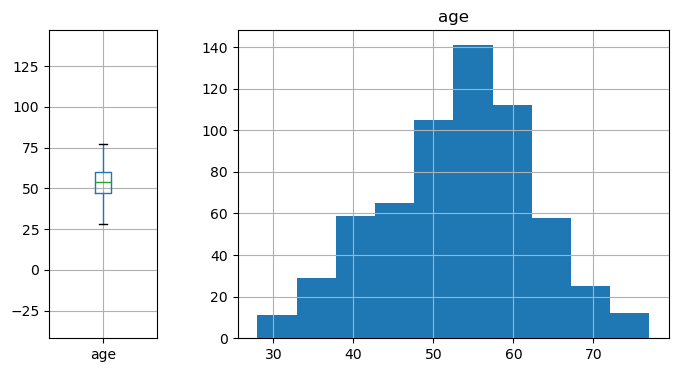

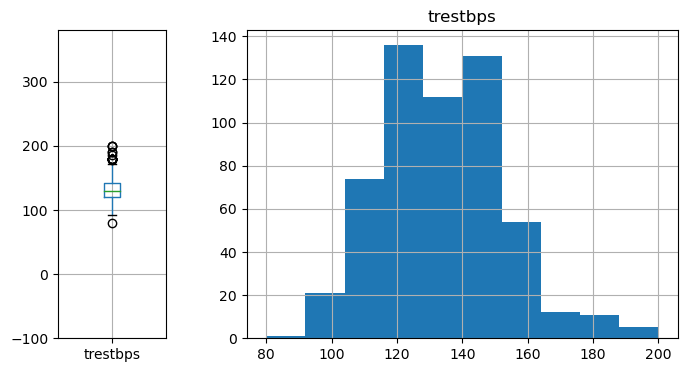

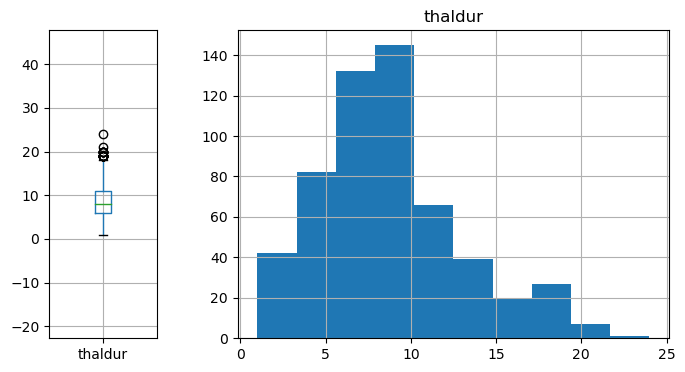

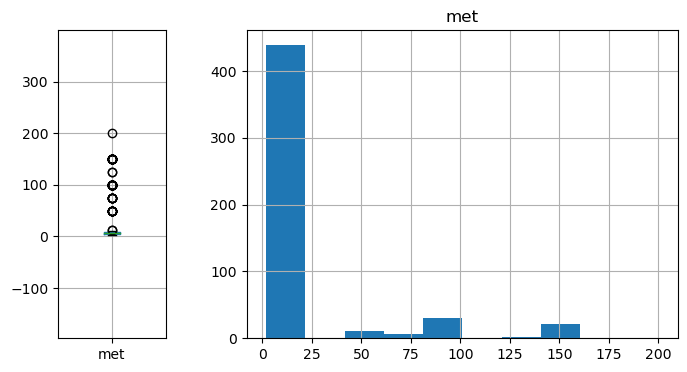

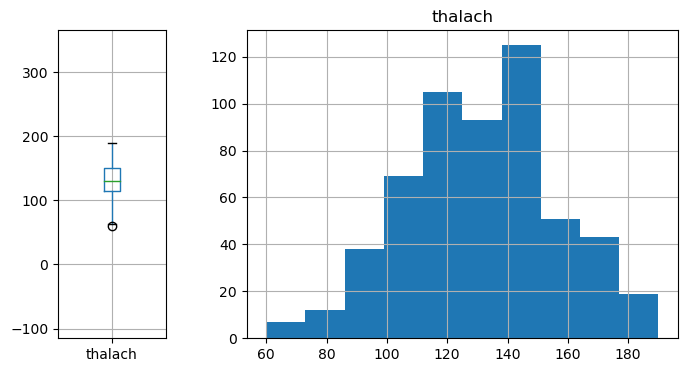

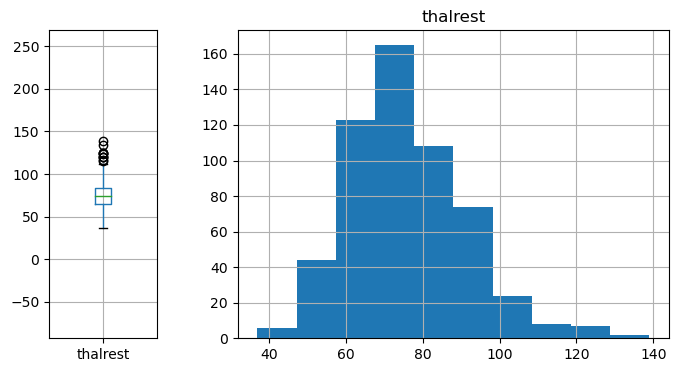

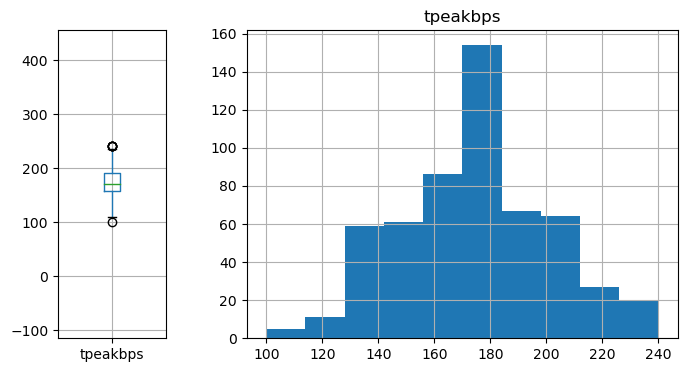

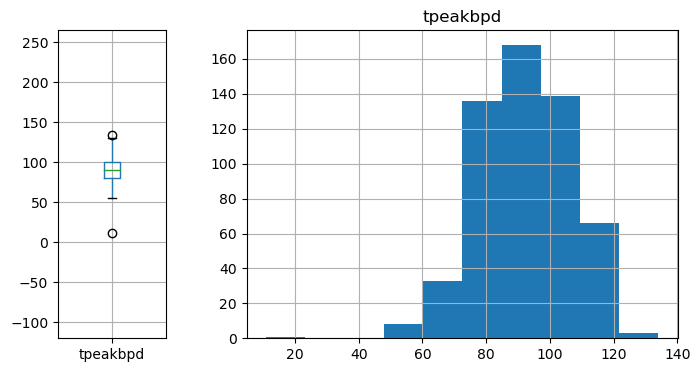

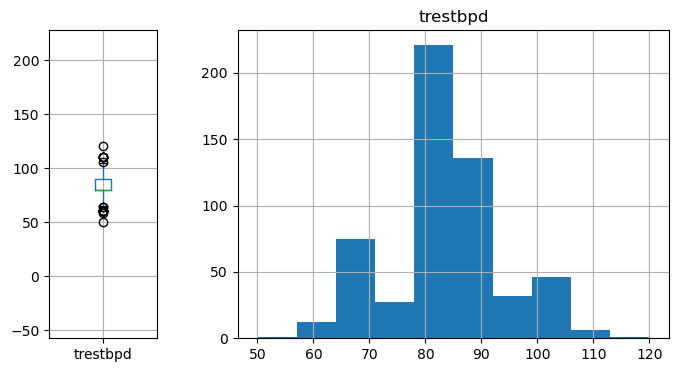

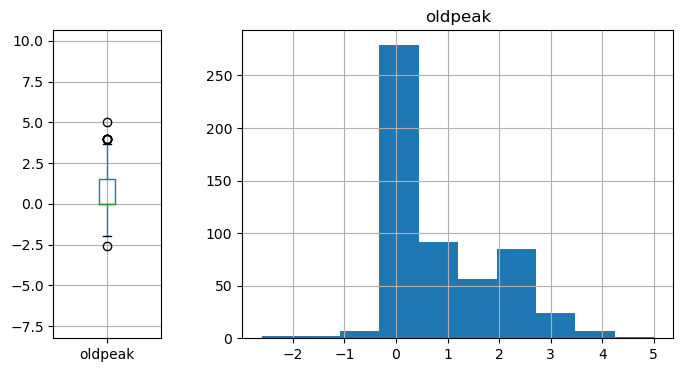

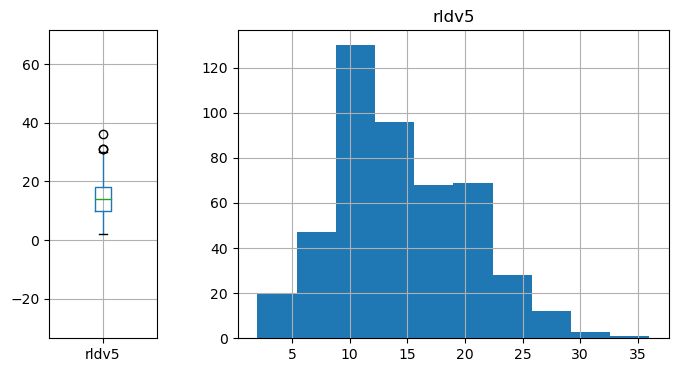

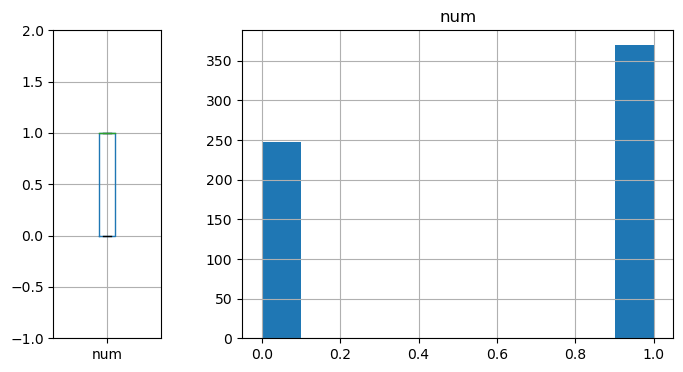

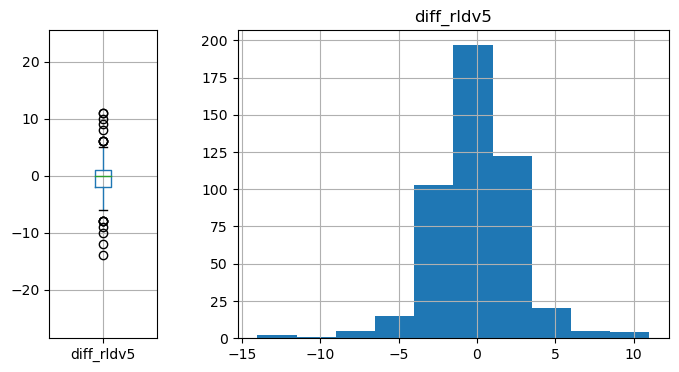

In [60]:
for col in df.columns:
  if df[col].dtype != "category":
    fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(8,4))
    axes[0].set_ylim((min(df[col]) - (max(df[col]) - min(df[col])/4), max(df[col]) + (max(df[col]) - min(df[col])/4)))
    df.boxplot(column=col,ax=axes[0]);
    df.hist(column=col, ax=axes[1]);


- tpeakbddp deu tenir un error
- met té valors massa alts.


In [61]:
print("Percentatge d'outliers a met:", len(df.loc[df["met"] > 25])/len(df), "%")
print("Total d'outliers a tpeakbpd:", len(df.loc[df["tpeakbpd"] < 20]))

Percentatge d'outliers a met: 0.11831442463533225 %
Total d'outliers a tpeakbpd: 1


Amb met és més d'un 10%, així que el posem com a NaN. En canvi, tpeakbpdd és només 1 instància, així que l'eliminem.

In [62]:
df = df[df["tpeakbpd"] != 11]
df.loc[df["met"] > 25, "met"] = np.nan

## Anàlisi exploratòria

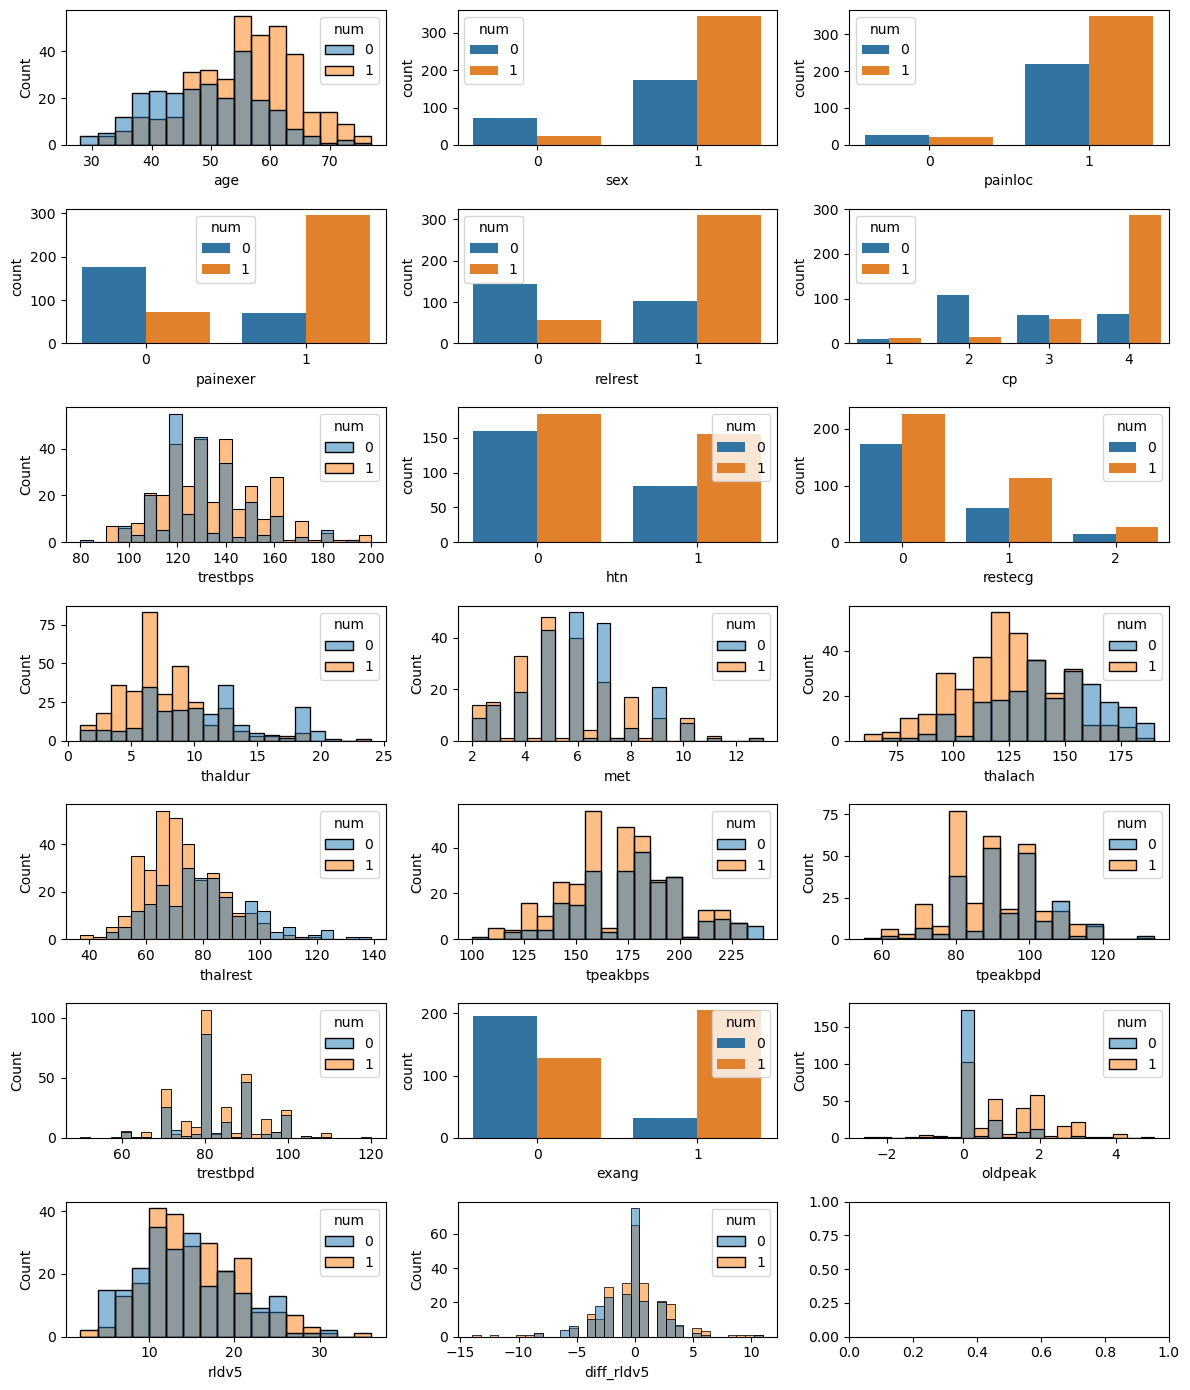

In [63]:
fig, axes = plt.subplots(7,3,figsize=(12,14));


for i, c in enumerate([col for col in df.columns if col != "num"]):
    if c == "num":
      continue
    ax = axes.reshape(-1)[i]
    if c in df.select_dtypes(include=['category']).columns:
        a = sns.countplot(x=c,data=df, ax=ax, hue='num');
    else:
        sns.histplot(x=c,data=df, hue='num',ax=ax);
plt.tight_layout();

## Variables correlades

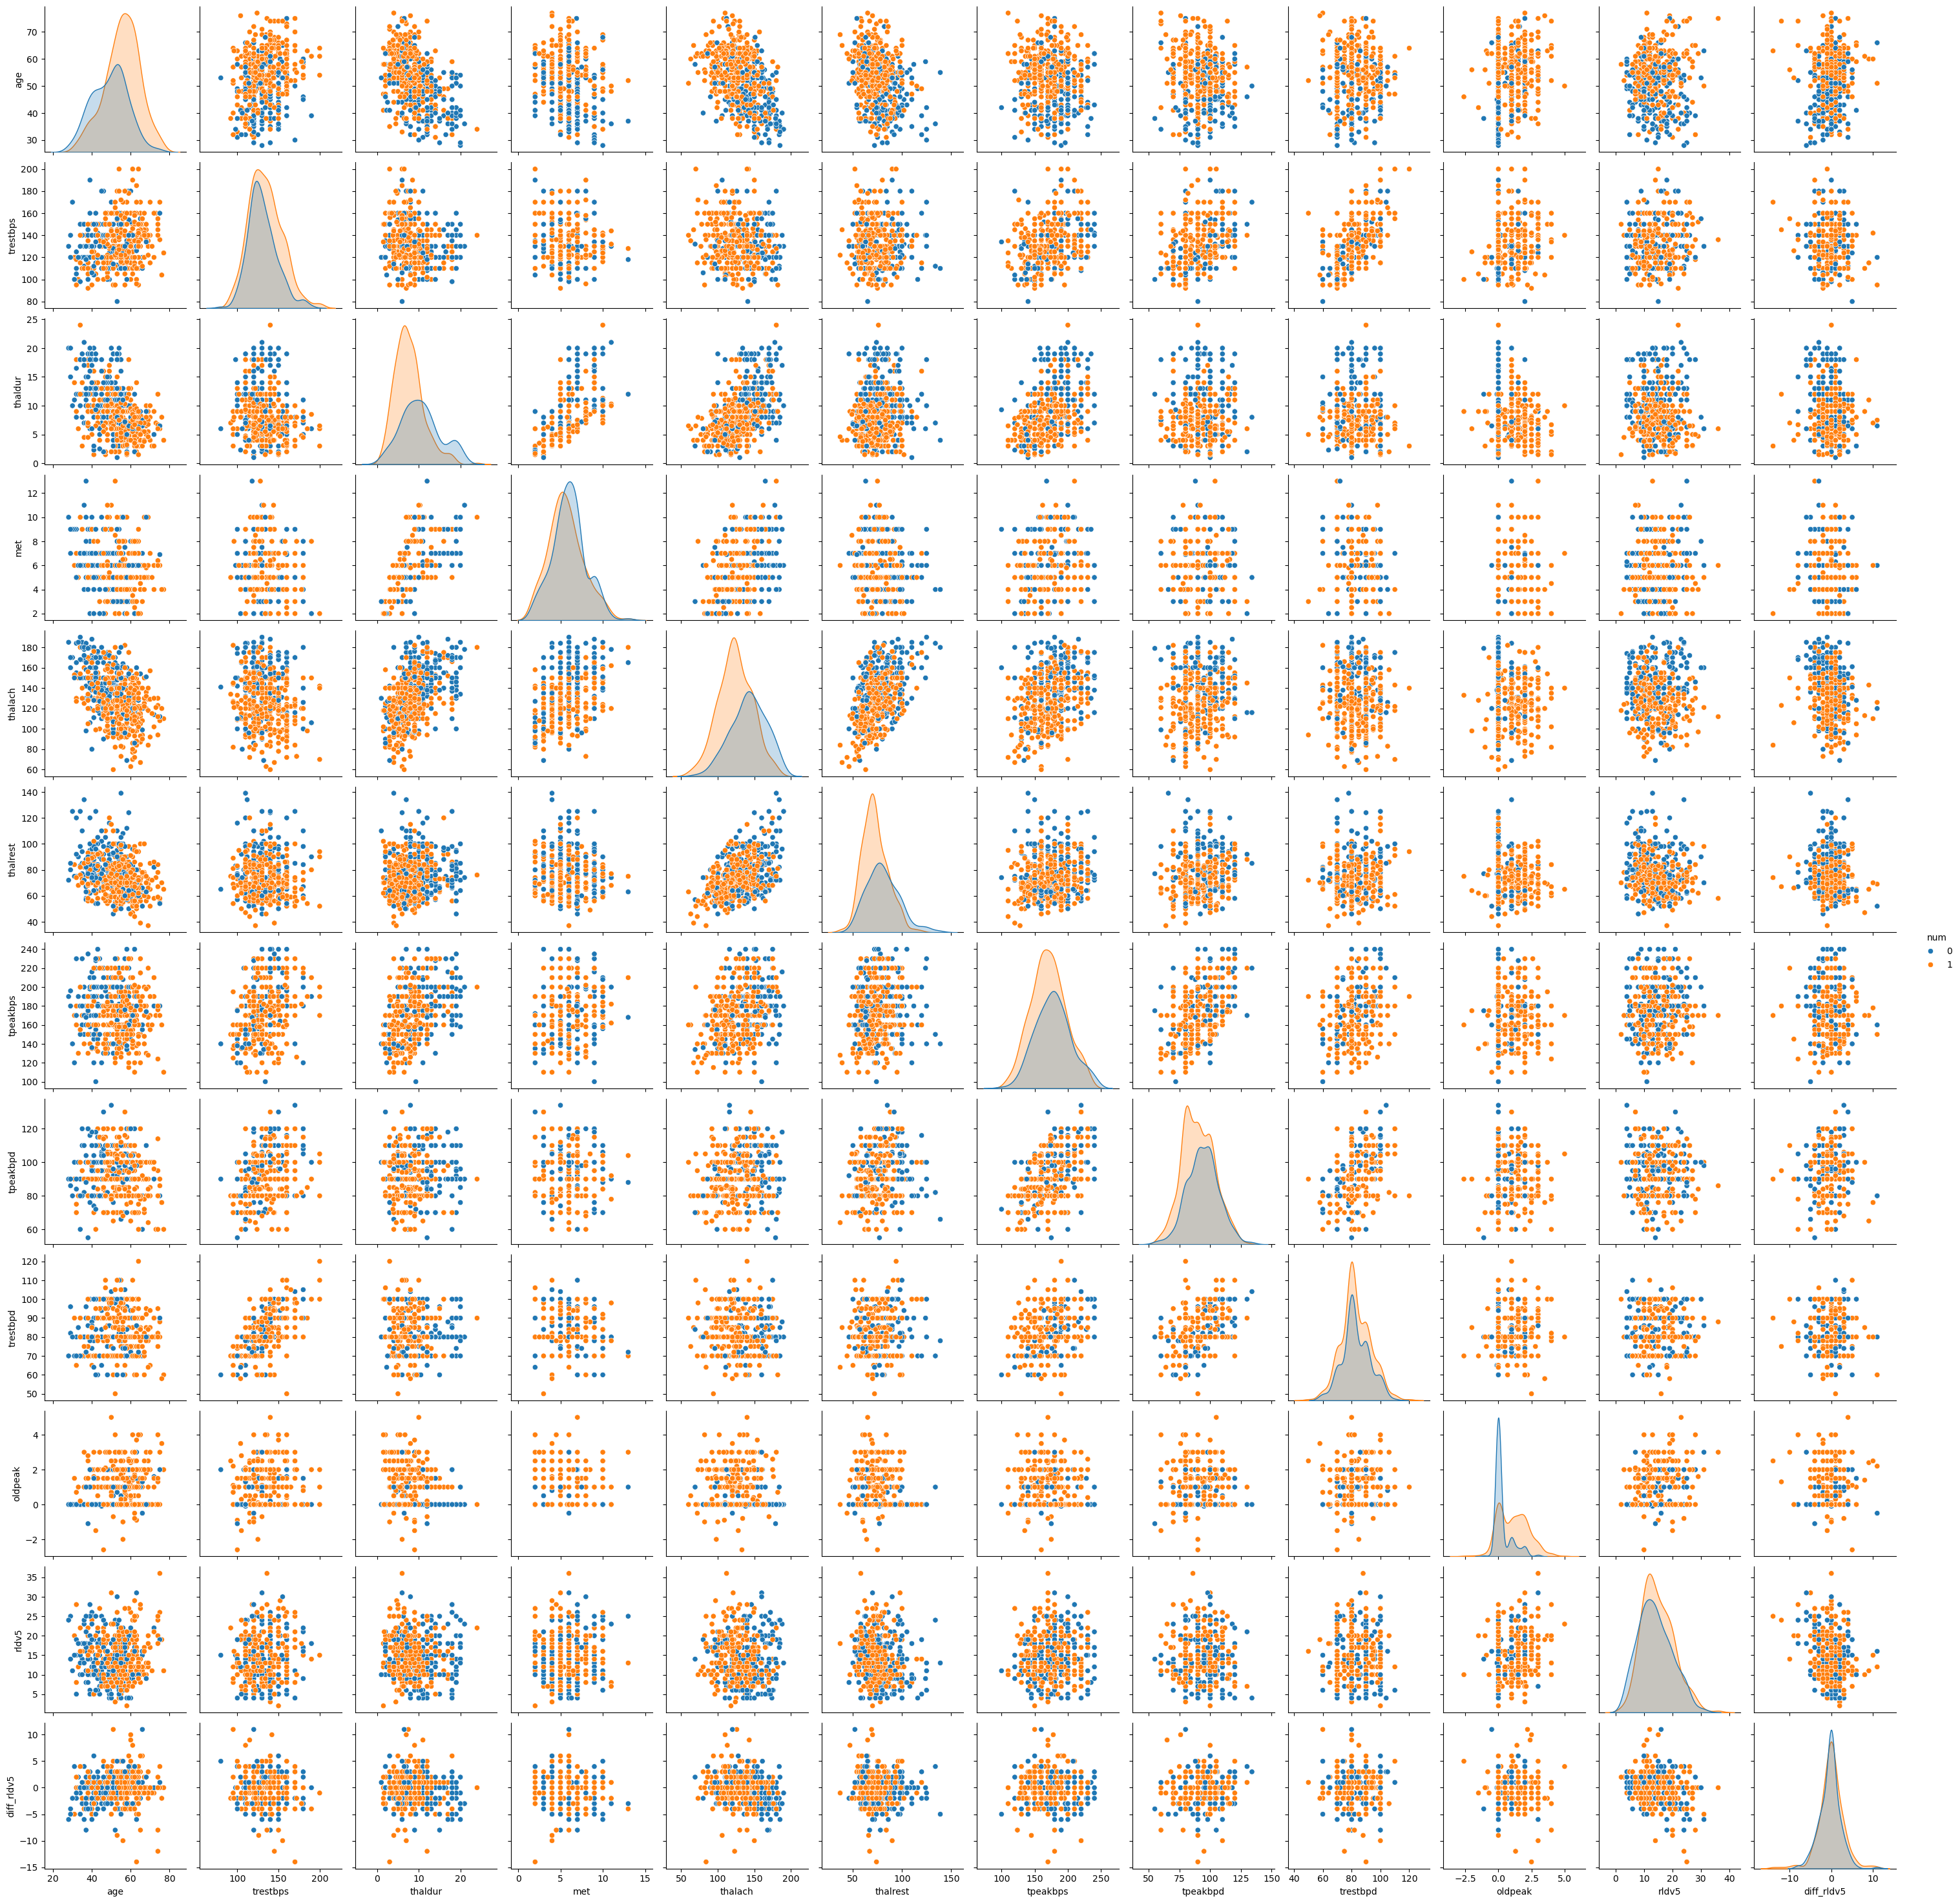

In [64]:
sns.pairplot(data=df, hue='num');

In [65]:
df['num']=pd.to_numeric(df['num'])

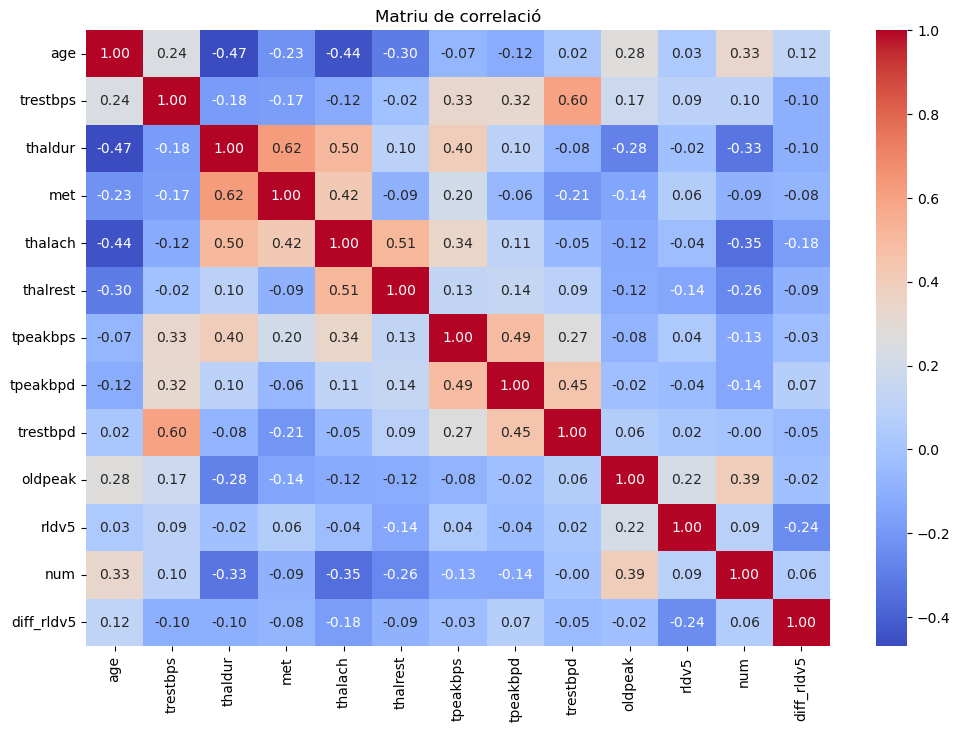

In [66]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

correlation_matrix = df[num_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriu de correlació')
plt.show()

In [67]:
df['num'] = df['num'].astype('category')

## Tractament de variables categòriques

In [68]:
len(df)

616

In [69]:
# percentatge de NaNs

cat_cols = df.select_dtypes(include=['category']).columns

missing_cats = []
for c in cat_cols:
    count = df[c].isna().sum()
    if count > 0:
      missing_cats.append(c)
      print(c, df[c].dtype, count, str(count/len(df)*100) + "%")

relrest category 4 0.6493506493506493%
htn category 34 5.51948051948052%
restecg category 2 0.3246753246753247%
exang category 55 8.928571428571429%


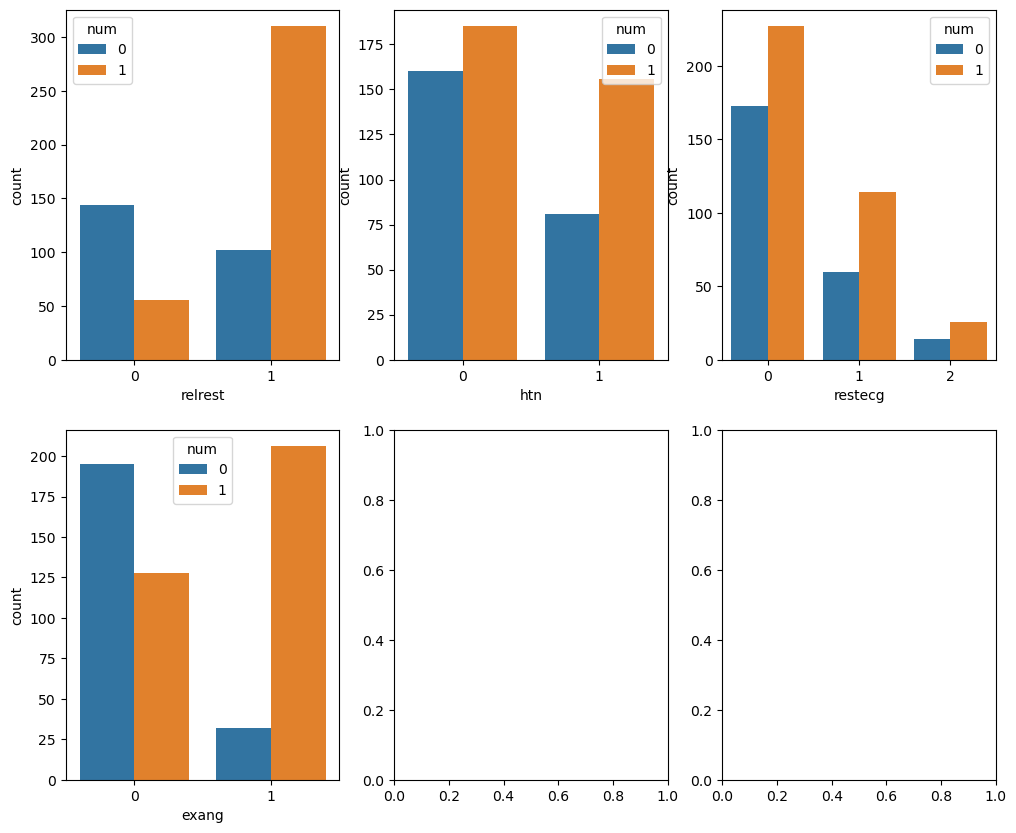

In [70]:
fig, axes = plt.subplots(2,3,figsize=(12,10));

for i, c in enumerate(missing_cats):
    if c == "num":
      continue
    ax = axes.reshape(-1)[i]
    a = sns.countplot(x=c,data=df, ax=ax, hue='num');

- Exang és molt important.

In [71]:
#df.drop("pro", axis=1, inplace=True)
df.dropna(subset=df.select_dtypes(include=['category']).columns, axis=0, inplace=True)
len(df)

524

In [72]:
# one hot encoding excepte al target

cat_cols = df.select_dtypes(include=['category']).columns
cat_no_target = cat_cols.drop(['num'])
encoded_cat = pd.get_dummies(df[cat_no_target], columns = cat_no_target)

df = pd.concat([df, encoded_cat], axis=1)
df = df.drop(cat_no_target, axis=1)

df

print(df.dtypes)

age              int64
trestbps       float64
thaldur        float64
met            float64
thalach        float64
thalrest       float64
tpeakbps       float64
tpeakbpd       float64
trestbpd       float64
oldpeak        float64
rldv5          float64
num           category
diff_rldv5     float64
sex_0             bool
sex_1             bool
painloc_0         bool
painloc_1         bool
painexer_0        bool
painexer_1        bool
relrest_0         bool
relrest_1         bool
cp_1              bool
cp_2              bool
cp_3              bool
cp_4              bool
htn_0             bool
htn_1             bool
restecg_0         bool
restecg_1         bool
restecg_2         bool
exang_0           bool
exang_1           bool
dtype: object


## Train test split

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["num"]), df["num"], test_size=0.2, random_state=1234)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

X_train

(419, 31)
(419,)
(105, 31)
(105,)


age  trestbps  thaldur  met  thalach  thalrest  tpeakbps  tpeakbpd  \
460   41     104.0      2.3  2.0    111.0      72.0     120.0      80.0   
465   59       NaN      5.0  5.0    128.0      73.0     120.0      80.0   
74    55     140.0     11.0  5.0    128.0      90.0     200.0     110.0   
586   57     180.0      4.5  5.0    120.0      72.0       NaN       NaN   
454   60     120.0      6.0  6.0    133.0      64.0     180.0      90.0   
..   ...       ...      ...  ...      ...       ...       ...       ...   
281   60     120.0     10.0  5.0    135.0      73.0     145.0      90.0   
407   57     140.0      6.0  NaN    100.0      78.0     170.0     110.0   
204   31     100.0     11.0  9.0    150.0      75.0     120.0     100.0   
53    41     130.0     12.0  6.0    150.0      77.0     170.0      95.0   
297   50     145.0      6.5  NaN    139.0      82.0     180.0      95.0   

     trestbpd  oldpeak  ...   cp_2   cp_3   cp_4  htn_0  htn_1  restecg_0  \
460      64.0      0.0  ...  False  False   True   True  False      False   
465       NaN      2.0  ...  False   True  False   True  False       True   
74       90.0      1.5  ...  False  False   True   True  False       True   
586      80.0      0.8  ...   True  False  False  False   True      False   
454      72.0      2.0  ...  False  False   True   True  False       True   
..        ...      ...  ...    ...    ...    ...    ...    ...        ...   
281      80.0      0.0  ...  False   True  False   True  False      False   
407      95.0      0.0  ...  False  False   True  False   True       True   
204      70.0      0.0  ...   True  False  False   True  False      False   
53       90.0      0.0  ...   True  False  False   True  False       True   
297      90.0      0.7  ...  False  False   True   True  False       True   

     restecg_1  restecg_2  exang_0  exang_1  
460       True      False     True    False  
465      False      False    False     True  
74       False      False    False     True  
586       True      False     True    False  
454      False      False    False     True  
..         ...        ...      ...      ...  
281      False       True     True    False  
407      False      False    False     True  
204       True      False     True    False  
53       False      False     True    False  
297      False      False    False     True  

[419 rows x 31 columns]

## Escalat de variables numèriques

In [74]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), columns=df[num_cols].columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=df[num_cols].columns)


X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)


X_train = pd.concat([X_train_scaled, X_train[encoded_cat.columns]], axis=1)
X_test = pd.concat([X_test_scaled, X_test[encoded_cat.columns]], axis=1)


X_train

age  trestbps   thaldur       met   thalach  thalrest  tpeakbps  \
0    0.276596  0.111111  0.056522  0.000000  0.392308      0.33  0.142857   
1    0.659574       NaN  0.173913  0.272727  0.523077      0.34  0.142857   
2    0.574468  0.444444  0.434783  0.272727  0.523077      0.51  0.714286   
3    0.617021  0.814815  0.152174  0.272727  0.461538      0.33       NaN   
4    0.680851  0.259259  0.217391  0.363636  0.561538      0.25  0.571429   
..        ...       ...       ...       ...       ...       ...       ...   
414  0.680851  0.259259  0.391304  0.272727  0.576923      0.34  0.321429   
415  0.617021  0.444444  0.217391       NaN  0.307692      0.39  0.500000   
416  0.063830  0.074074  0.434783  0.636364  0.692308      0.36  0.142857   
417  0.276596  0.351852  0.478261  0.363636  0.692308      0.38  0.500000   
418  0.468085  0.490741  0.239130       NaN  0.607692      0.43  0.571429   

     tpeakbpd  trestbpd   oldpeak  ...   cp_2   cp_3   cp_4  htn_0  htn_1  \
0    0.285714  0.200000  0.285714  ...  False  False   True   True  False   
1    0.285714       NaN  0.571429  ...  False   True  False   True  False   
2    0.714286  0.571429  0.500000  ...  False  False   True   True  False   
3         NaN  0.428571  0.400000  ...   True  False  False  False   True   
4    0.428571  0.314286  0.571429  ...  False  False   True   True  False   
..        ...       ...       ...  ...    ...    ...    ...    ...    ...   
414  0.428571  0.428571  0.285714  ...  False   True  False   True  False   
415  0.714286  0.642857  0.285714  ...  False  False   True  False   True   
416  0.571429  0.285714  0.285714  ...   True  False  False   True  False   
417  0.500000  0.571429  0.285714  ...   True  False  False   True  False   
418  0.500000  0.571429  0.385714  ...  False  False   True   True  False   

     restecg_0  restecg_1  restecg_2  exang_0  exang_1  
0        False       True      False     True    False  
1         True      False      False    False     True  
2         True      False      False    False     True  
3        False       True      False     True    False  
4         True      False      False    False     True  
..         ...        ...        ...      ...      ...  
414      False      False       True     True    False  
415       True      False      False    False     True  
416      False       True      False     True    False  
417       True      False      False     True    False  
418       True      False      False    False     True  

[419 rows x 31 columns]

## Imputació de valors

In [75]:
imputer = KNNImputer()
X_train_scaled = imputer.fit_transform(X_train)
X_test_scaled = imputer.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train

age  trestbps   thaldur       met   thalach  thalrest  tpeakbps  \
0    0.276596  0.111111  0.056522  0.000000  0.392308      0.33  0.142857   
1    0.659574  0.324074  0.173913  0.272727  0.523077      0.34  0.142857   
2    0.574468  0.444444  0.434783  0.272727  0.523077      0.51  0.714286   
3    0.617021  0.814815  0.152174  0.272727  0.461538      0.33  0.580000   
4    0.680851  0.259259  0.217391  0.363636  0.561538      0.25  0.571429   
..        ...       ...       ...       ...       ...       ...       ...   
414  0.680851  0.259259  0.391304  0.272727  0.576923      0.34  0.321429   
415  0.617021  0.444444  0.217391  0.218182  0.307692      0.39  0.500000   
416  0.063830  0.074074  0.434783  0.636364  0.692308      0.36  0.142857   
417  0.276596  0.351852  0.478261  0.363636  0.692308      0.38  0.500000   
418  0.468085  0.490741  0.239130  0.345455  0.607692      0.43  0.571429   

     tpeakbpd  trestbpd   oldpeak  ...  cp_2  cp_3  cp_4  htn_0  htn_1  \
0    0.285714  0.200000  0.285714  ...   0.0   0.0   1.0    1.0    0.0   
1    0.285714  0.485714  0.571429  ...   0.0   1.0   0.0    1.0    0.0   
2    0.714286  0.571429  0.500000  ...   0.0   0.0   1.0    1.0    0.0   
3    0.428571  0.428571  0.400000  ...   1.0   0.0   0.0    0.0    1.0   
4    0.428571  0.314286  0.571429  ...   0.0   0.0   1.0    1.0    0.0   
..        ...       ...       ...  ...   ...   ...   ...    ...    ...   
414  0.428571  0.428571  0.285714  ...   0.0   1.0   0.0    1.0    0.0   
415  0.714286  0.642857  0.285714  ...   0.0   0.0   1.0    0.0    1.0   
416  0.571429  0.285714  0.285714  ...   1.0   0.0   0.0    1.0    0.0   
417  0.500000  0.571429  0.285714  ...   1.0   0.0   0.0    1.0    0.0   
418  0.500000  0.571429  0.385714  ...   0.0   0.0   1.0    1.0    0.0   

     restecg_0  restecg_1  restecg_2  exang_0  exang_1  
0          0.0        1.0        0.0      1.0      0.0  
1          1.0        0.0        0.0      0.0      1.0  
2          1.0        0.0        0.0      0.0      1.0  
3          0.0        1.0        0.0      1.0      0.0  
4          1.0        0.0        0.0      0.0      1.0  
..         ...        ...        ...      ...      ...  
414        0.0        0.0        1.0      1.0      0.0  
415        1.0        0.0        0.0      0.0      1.0  
416        0.0        1.0        0.0      1.0      0.0  
417        1.0        0.0        0.0      1.0      0.0  
418        1.0        0.0        0.0      0.0      1.0  

[419 rows x 31 columns]

In [76]:
X_train[encoded_cat.columns] = X_train[encoded_cat.columns].astype('bool')
X_test[encoded_cat.columns] = X_test[encoded_cat.columns].astype('bool')

X_train

age  trestbps   thaldur       met   thalach  thalrest  tpeakbps  \
0    0.276596  0.111111  0.056522  0.000000  0.392308      0.33  0.142857   
1    0.659574  0.324074  0.173913  0.272727  0.523077      0.34  0.142857   
2    0.574468  0.444444  0.434783  0.272727  0.523077      0.51  0.714286   
3    0.617021  0.814815  0.152174  0.272727  0.461538      0.33  0.580000   
4    0.680851  0.259259  0.217391  0.363636  0.561538      0.25  0.571429   
..        ...       ...       ...       ...       ...       ...       ...   
414  0.680851  0.259259  0.391304  0.272727  0.576923      0.34  0.321429   
415  0.617021  0.444444  0.217391  0.218182  0.307692      0.39  0.500000   
416  0.063830  0.074074  0.434783  0.636364  0.692308      0.36  0.142857   
417  0.276596  0.351852  0.478261  0.363636  0.692308      0.38  0.500000   
418  0.468085  0.490741  0.239130  0.345455  0.607692      0.43  0.571429   

     tpeakbpd  trestbpd   oldpeak  ...   cp_2   cp_3   cp_4  htn_0  htn_1  \
0    0.285714  0.200000  0.285714  ...  False  False   True   True  False   
1    0.285714  0.485714  0.571429  ...  False   True  False   True  False   
2    0.714286  0.571429  0.500000  ...  False  False   True   True  False   
3    0.428571  0.428571  0.400000  ...   True  False  False  False   True   
4    0.428571  0.314286  0.571429  ...  False  False   True   True  False   
..        ...       ...       ...  ...    ...    ...    ...    ...    ...   
414  0.428571  0.428571  0.285714  ...  False   True  False   True  False   
415  0.714286  0.642857  0.285714  ...  False  False   True  False   True   
416  0.571429  0.285714  0.285714  ...   True  False  False   True  False   
417  0.500000  0.571429  0.285714  ...   True  False  False   True  False   
418  0.500000  0.571429  0.385714  ...  False  False   True   True  False   

     restecg_0  restecg_1  restecg_2  exang_0  exang_1  
0        False       True      False     True    False  
1         True      False      False    False     True  
2         True      False      False    False     True  
3        False       True      False     True    False  
4         True      False      False    False     True  
..         ...        ...        ...      ...      ...  
414      False      False       True     True    False  
415       True      False      False    False     True  
416      False       True      False     True    False  
417       True      False      False     True    False  
418       True      False      False    False     True  

[419 rows x 31 columns]

In [77]:
train_data = pd.concat([X_train, y_train], axis=1)
train_data.to_csv('data/train_data.csv', index=False)

test_data = pd.concat([X_test, y_test], axis=1)
test_data.to_csv('data/test_data.csv', index=False)